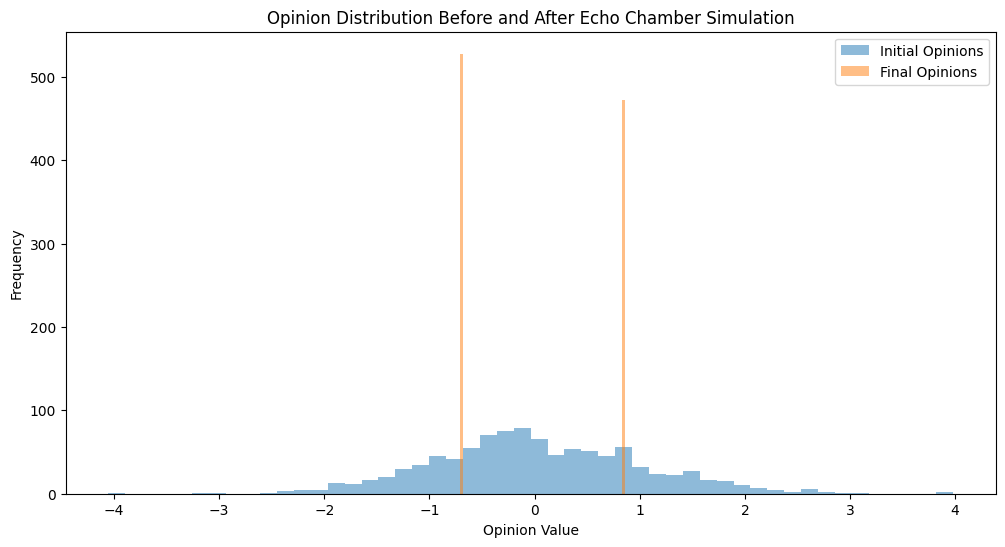

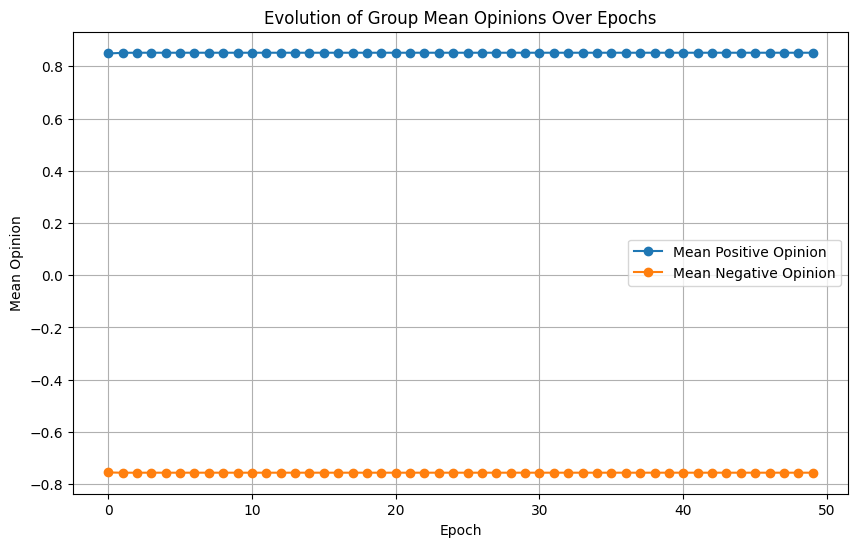

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Simulation Parameters
# --------------------------
N = 1000              # Population size (using a smaller N for faster simulation)
epochs = 50           # Number of epochs (each epoch = N tweets)
tweets_per_epoch = N  # Tweets per epoch
lambda_val = 0.005    # Influence step size

# --------------------------
# Initial Opinion Setup
# --------------------------
# Opinions are drawn from a Gaussian distribution (mean=0, std=1)
opinions_initial = np.random.normal(0, 1, N)
opinions = opinions_initial.copy()

# --------------------------
# Simulation of Echo Chamber Dynamics
# --------------------------
# In each tweet, a randomly selected individual (the "tweeter") broadcasts their opinion.
# Only individuals whose opinions are on the same side (i.e. have the same sign) are exposed,
# and they update their opinion slightly towards the tweeter's stance.
for epoch in range(epochs):
    for _ in range(tweets_per_epoch):
        # Randomly select a tweeter
        tweeter_idx = np.random.randint(0, N)
        tweet_opinion = opinions[tweeter_idx]

        # Determine which individuals share the same "side"
        # (Here, we assume sign(0) is rare; if it occurs, you might decide on a rule)
        mask = np.sign(opinions) == np.sign(tweet_opinion)

        # Update opinions: move each exposed individual's opinion a fraction lambda towards tweet_opinion
        opinions[mask] += lambda_val * (tweet_opinion - opinions[mask])

# --------------------------
# Plotting the Results
# --------------------------
plt.figure(figsize=(12, 6))
plt.hist(opinions_initial, bins=50, alpha=0.5, label='Initial Opinions')
plt.hist(opinions, bins=50, alpha=0.5, label='Final Opinions')
plt.xlabel("Opinion Value")
plt.ylabel("Frequency")
plt.title("Opinion Distribution Before and After Echo Chamber Simulation")
plt.legend()
plt.show()

# Optionally, you can also track and plot the evolution of the mean opinions
# of the positive and negative camps over epochs.
history_mean_pos = []
history_mean_neg = []

# Reset opinions for tracking evolution (using the same initial conditions)
opinions = opinions_initial.copy()

for epoch in range(epochs):
    for _ in range(tweets_per_epoch):
        tweeter_idx = np.random.randint(0, N)
        tweet_opinion = opinions[tweeter_idx]
        mask = np.sign(opinions) == np.sign(tweet_opinion)
        opinions[mask] += lambda_val * (tweet_opinion - opinions[mask])

    # Compute group means for those with positive and negative opinions
    pos_mask = opinions > 0
    neg_mask = opinions < 0
    history_mean_pos.append(np.mean(opinions[pos_mask]) if np.sum(pos_mask) > 0 else 0)
    history_mean_neg.append(np.mean(opinions[neg_mask]) if np.sum(neg_mask) > 0 else 0)

plt.figure(figsize=(10, 6))
plt.plot(range(epochs), history_mean_pos, label="Mean Positive Opinion", marker='o')
plt.plot(range(epochs), history_mean_neg, label="Mean Negative Opinion", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Mean Opinion")
plt.title("Evolution of Group Mean Opinions Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


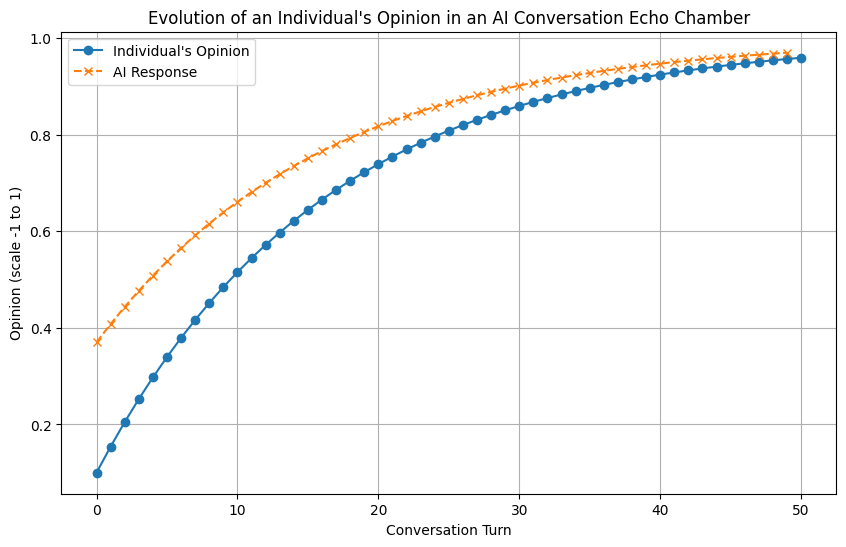

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Simulation Parameters
# --------------------------
T = 50                 # Number of conversation turns
lambda_val = 0.2       # Learning rate: fraction by which the individual shifts toward the AI's message each turn
beta = 0.3             # Reinforcement factor: determines how “extreme” the AI response is relative to the current opinion

# --------------------------
# AI Response Function
# --------------------------
def ai_response(opinion, beta=0.3):
    """
    Generates an AI response that reinforces the individual's current opinion.

    Parameters:
        opinion (float): The individual's current opinion (scale -1 to 1).
        beta (float): The reinforcement factor.

    Returns:
        float: The AI's tailored response.

    Assumptions:
    - If the individual's opinion is exactly zero, the AI picks a random direction.
    - For non-zero opinions, the AI adds an extra push in the same direction.
    - The magnitude of the push decreases as the opinion becomes more extreme.
    """
    if opinion == 0:
        # If opinion is exactly neutral, randomly choose a direction to push (could be refined further)
        return np.random.choice([-1, 1]) * beta
    else:
        # Calculate reinforcement that diminishes as |opinion| approaches 1
        reinforcement = beta * (1 - abs(opinion))
        return opinion + reinforcement * np.sign(opinion)

# --------------------------
# Simulation of the Conversation
# --------------------------
opinions = np.zeros(T + 1)   # To store the individual's opinion at each turn
ai_messages = np.zeros(T)    # To store the AI's responses at each turn

# Set an initial moderate opinion (could be positive or negative)
opinions[0] = 0.1

for t in range(T):
    # AI generates a response tailored to the individual's current opinion
    ai_msg = ai_response(opinions[t], beta)
    ai_messages[t] = ai_msg

    # Update the individual's opinion by moving a fraction (lambda_val) toward the AI's message
    opinions[t + 1] = opinions[t] + lambda_val * (ai_msg - opinions[t])

# --------------------------
# Plotting the Results
# --------------------------
plt.figure(figsize=(10, 6))
plt.plot(range(T + 1), opinions, marker='o', label="Individual's Opinion")
plt.plot(range(T), ai_messages, marker='x', linestyle='--', label="AI Response")
plt.xlabel("Conversation Turn")
plt.ylabel("Opinion (scale -1 to 1)")
plt.title("Evolution of an Individual's Opinion in an AI Conversation Echo Chamber")
plt.legend()
plt.grid(True)
plt.show()


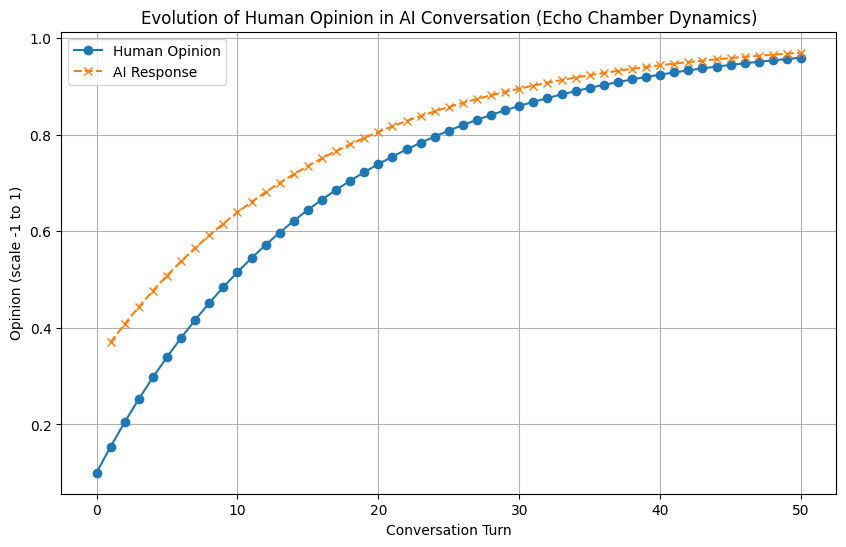

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Message Class (Optional)
# --------------------------
class Message:
    def __init__(self, sender, content, turn):
        self.sender = sender  # 'Human' or 'AI'
        self.content = content  # the opinion value
        self.turn = turn

    def __repr__(self):
        return f"Turn {self.turn}: {self.sender} says {self.content:.3f}"


# --------------------------
# Human Agent
# --------------------------
class HumanAgent:
    def __init__(self, initial_opinion, epsilon, mu):
        """
        initial_opinion: float in [-1, 1] representing the starting view.
        epsilon: tolerance threshold; the human only accepts AI responses that are within epsilon.
        mu: learning rate for opinion updating.
        """
        self.opinion = initial_opinion
        self.epsilon = epsilon
        self.mu = mu
        self.message_history = []  # store messages sent by the human

    def post_message(self, turn):
        """
        Human posts their current opinion as a message.
        """
        msg = Message("Human", self.opinion, turn)
        self.message_history.append(msg)
        return msg

    def evaluate_and_update(self, ai_message):
        """
        Evaluate the AI's message. If the AI response is "concordant" (i.e. the difference between
        the human's opinion and the AI message is less than epsilon), then update the opinion towards
        the AI's message using the learning rate mu.
        """
        diff = abs(self.opinion - ai_message.content)
        if diff < self.epsilon:
            # Update opinion
            self.opinion += self.mu * (ai_message.content - self.opinion)
        # Otherwise, no update (i.e., the human rejects a message that is too discordant)


# --------------------------
# AI Agent
# --------------------------
class AIAgent:
    def __init__(self, beta):
        """
        beta: reinforcement factor for exaggeration. Determines how much more extreme the AI response is.
        """
        self.beta = beta
        self.message_history = []  # store AI messages

    def generate_response(self, human_opinion, turn):
        """
        Generates a response based on the human's current opinion.
        If the human opinion is zero, picks a random direction.
        Otherwise, the AI amplifies the opinion by a reinforcement factor that decreases as the opinion nears the extremes.
        """
        if human_opinion == 0:
            # If neutral, choose a random direction to push
            direction = np.random.choice([-1, 1])
            ai_content = self.beta * direction
        else:
            reinforcement = self.beta * (1 - abs(human_opinion))
            ai_content = human_opinion + reinforcement * np.sign(human_opinion)
            # Clip to ensure the response remains in [-1, 1]
            ai_content = np.clip(ai_content, -1, 1)
        msg = Message("AI", ai_content, turn)
        self.message_history.append(msg)
        return msg


# --------------------------
# Conversation Dynamics
# --------------------------
class ConversationDynamics:
    def __init__(self, human_agent, ai_agent, T):
        """
        human_agent: instance of HumanAgent.
        ai_agent: instance of AIAgent.
        T: total number of conversation turns.
        """
        self.human = human_agent
        self.ai = ai_agent
        self.T = T
        self.conversation_history = []  # stores all messages in order
        self.human_opinions = [human_agent.opinion]  # track human opinions over time

    def run(self):
        for t in range(1, self.T + 1):
            # Step 1: Human posts a message (current opinion)
            human_msg = self.human.post_message(t)
            self.conversation_history.append(human_msg)

            # Step 2: AI generates a response based on the human's current opinion
            ai_msg = self.ai.generate_response(self.human.opinion, t)
            self.conversation_history.append(ai_msg)

            # Step 3: Human evaluates the AI's response and updates opinion if within tolerance
            self.human.evaluate_and_update(ai_msg)

            # Record the updated human opinion
            self.human_opinions.append(self.human.opinion)

    def plot_conversation(self):
        turns = np.arange(0, self.T + 1)
        plt.figure(figsize=(10, 6))
        plt.plot(turns, self.human_opinions, marker='o', label="Human Opinion")
        # For AI messages, plot them at midpoints (optional)
        ai_turns = turns[1:]
        ai_contents = [msg.content for msg in self.ai.message_history]
        plt.plot(ai_turns, ai_contents, marker='x', linestyle='--', label="AI Response")
        plt.xlabel("Conversation Turn")
        plt.ylabel("Opinion (scale -1 to 1)")
        plt.title("Evolution of Human Opinion in AI Conversation (Echo Chamber Dynamics)")
        plt.legend()
        plt.grid(True)
        plt.show()

    def print_conversation(self):
        for msg in self.conversation_history:
            print(msg)


# --------------------------
# Simulation Setup and Run
# --------------------------
if __name__ == '__main__':
    # Simulation parameters:
    initial_opinion = 0.1    # human starts with a moderate opinion
    epsilon = 0.3            # human accepts AI responses within 0.3 of their current view
    mu = 0.2                 # learning rate for updating opinion
    beta = 0.3               # AI reinforcement factor
    T = 50                   # number of conversational turns

    # Create agents
    human = HumanAgent(initial_opinion, epsilon, mu)
    ai = AIAgent(beta)

    # Initialize conversation dynamics and run simulation
    conversation = ConversationDynamics(human, ai, T)
    conversation.run()

    # Optionally, print out the conversation log
    # conversation.print_conversation()

    # Plot the evolution of opinions and AI responses
    conversation.plot_conversation()


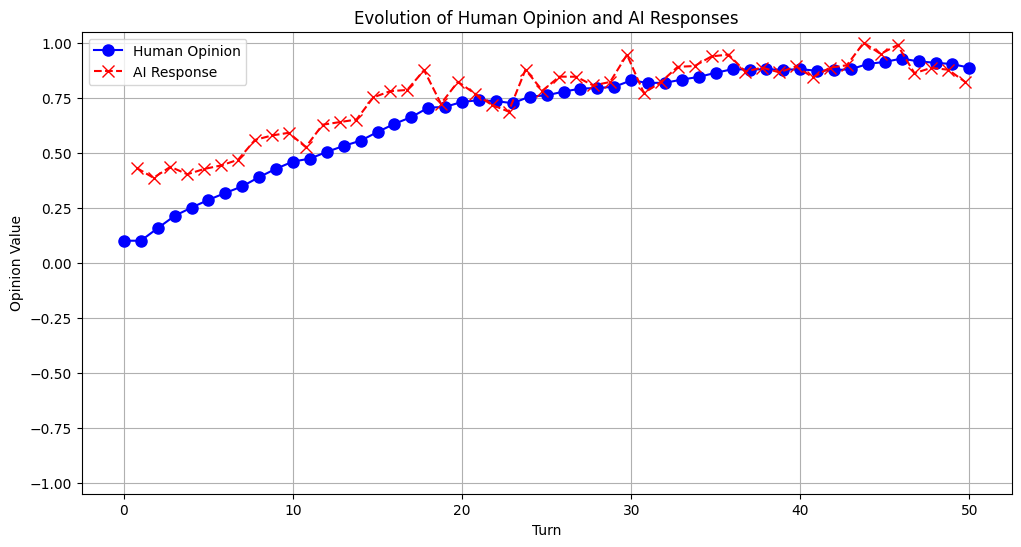

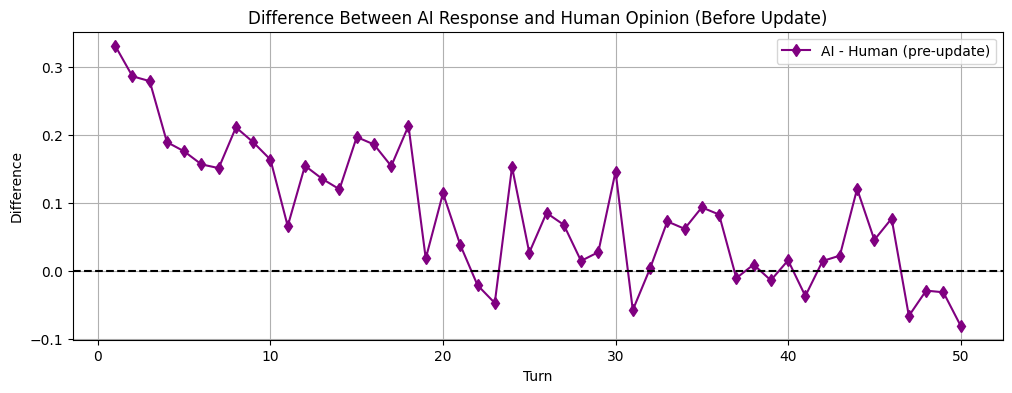

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Human Agent
# --------------------------
class HumanAgent:
    def __init__(self, initial_opinion=0.0, epsilon=0.3, mu=0.2):
        """
        initial_opinion: Starting opinion in [-1, 1]
        epsilon: Tolerance threshold; only AI responses within epsilon will be accepted
        mu: Learning rate (fraction of difference incorporated in each update)
        """
        self.opinion = initial_opinion
        self.epsilon = epsilon
        self.mu = mu
        self.history = [initial_opinion]  # Track opinion evolution

    def post_message(self, turn):
        """
        Returns the current opinion.
        """
        return self.opinion

    def update_opinion(self, ai_response):
        """
        Update the opinion only if the difference between the AI response and the current opinion
        is less than epsilon. The new opinion is a weighted blend of the current opinion and the AI response.
        """
        diff = abs(ai_response - self.opinion)
        if diff < self.epsilon:
            self.opinion = self.opinion + self.mu * (ai_response - self.opinion)
        # Clip to ensure opinion stays within [-1, 1]
        self.opinion = np.clip(self.opinion, -1, 1)
        self.history.append(self.opinion)

# --------------------------
# AI Agent
# --------------------------
class AIAgent:
    def __init__(self, beta=0.3, sigma=0.05):
        """
        beta: Reinforcement factor that controls how much the AI amplifies the human opinion.
        sigma: Standard deviation of noise added to the AI response.
        """
        self.beta = beta
        self.sigma = sigma
        self.history = []  # Track AI responses

    def generate_response(self, human_opinion):
        """
        Generates an AI response that echoes and amplifies the human opinion.
        If the opinion is exactly zero, choose a random direction.
        """
        if abs(human_opinion) < 1e-6:
            sign = np.random.choice([-1, 1])
        else:
            sign = np.sign(human_opinion)
        # Amplification diminishes as the opinion nears the extremes.
        reinforcement = self.beta * (1 - abs(human_opinion))
        ai_response = human_opinion + reinforcement * sign
        # Add a bit of noise to simulate variability.
        ai_response += np.random.normal(0, self.sigma)
        # Clip to the allowed range.
        ai_response = np.clip(ai_response, -1, 1)
        self.history.append(ai_response)
        return ai_response

# --------------------------
# Conversation Dynamics
# --------------------------
class Conversation:
    def __init__(self, human_agent, ai_agent, T=50):
        """
        human_agent: Instance of HumanAgent.
        ai_agent: Instance of AIAgent.
        T: Total number of conversation turns.
        """
        self.human = human_agent
        self.ai = ai_agent
        self.T = T

    def run(self):
        """
        Runs the conversation for T turns. In each turn:
          1. The human posts their current opinion.
          2. The AI generates a tailored response.
          3. The human evaluates the response and updates their opinion if the response is acceptable.
        """
        # For visualization, we record human and AI messages turn by turn.
        self.turns = []
        self.human_msgs = []
        self.ai_msgs = []

        for t in range(1, self.T + 1):
            # Human posts message.
            current_opinion = self.human.post_message(t)
            self.human_msgs.append(current_opinion)
            self.turns.append(t - 0.25)  # offset for visualization

            # AI generates a response.
            ai_response = self.ai.generate_response(current_opinion)
            self.ai_msgs.append(ai_response)
            self.turns.append(t + 0.25)  # offset for visualization

            # Human evaluates and updates opinion.
            self.human.update_opinion(ai_response)

        # Record final human opinion after T turns.
        self.human_msgs.append(self.human.opinion)
        self.turns.append(self.T + 0.5)

    def plot_conversation(self):
        """
        Generates two visualizations:
          1. A time series plot of the human's opinion (blue circles) and the AI responses (red crosses).
          2. A plot of the difference (AI response minus human opinion at time of response).
        """
        # Plot opinion evolution with AI responses.
        plt.figure(figsize=(12, 6))
        # Human opinions: plot at integer turn values (including initial opinion at turn 0)
        human_turns = np.arange(len(self.human.history))
        plt.plot(human_turns, self.human.history, '-o', label="Human Opinion", markersize=8, color='blue')
        # AI responses: plot them at midpoints between turns.
        ai_turns = np.linspace(0.75, self.T - 0.25, len(self.ai.history))
        plt.plot(ai_turns, self.ai.history, '--x', label="AI Response", markersize=8, color='red')
        plt.xlabel("Turn")
        plt.ylabel("Opinion Value")
        plt.title("Evolution of Human Opinion and AI Responses")
        plt.legend()
        plt.grid(True)
        plt.ylim(-1.05, 1.05)
        plt.show()

        # Plot the difference between the AI response and the human opinion at the time of response.
        # For this, we compare each AI response with the human opinion before the update.
        human_before = self.human.history[:-1]  # human opinion before update at each turn
        diffs = np.array(self.ai.history) - np.array(human_before)
        plt.figure(figsize=(12, 4))
        plt.plot(np.arange(1, self.T + 1), diffs, '-d', color='purple', label="AI - Human (pre-update)")
        plt.xlabel("Turn")
        plt.ylabel("Difference")
        plt.title("Difference Between AI Response and Human Opinion (Before Update)")
        plt.axhline(0, color='black', linestyle='--')
        plt.legend()
        plt.grid(True)
        plt.show()

# --------------------------
# Run the Simulation
# --------------------------
if __name__ == '__main__':
    # Set parameters for the human and AI.
    initial_opinion = 0.1   # Human starts with a moderate view.
    epsilon = 0.3           # Human will only update if the AI response is within 0.3 of current opinion.
    mu = 0.2                # Learning rate for the human's update.
    beta = 0.3              # AI reinforcement factor.
    sigma = 0.05            # Noise in AI response.
    T = 50                  # Number of conversation turns.

    # Initialize agents.
    human = HumanAgent(initial_opinion=initial_opinion, epsilon=epsilon, mu=mu)
    ai = AIAgent(beta=beta, sigma=sigma)

    # Create and run the conversation.
    conversation = Conversation(human, ai, T=T)
    conversation.run()
    conversation.plot_conversation()


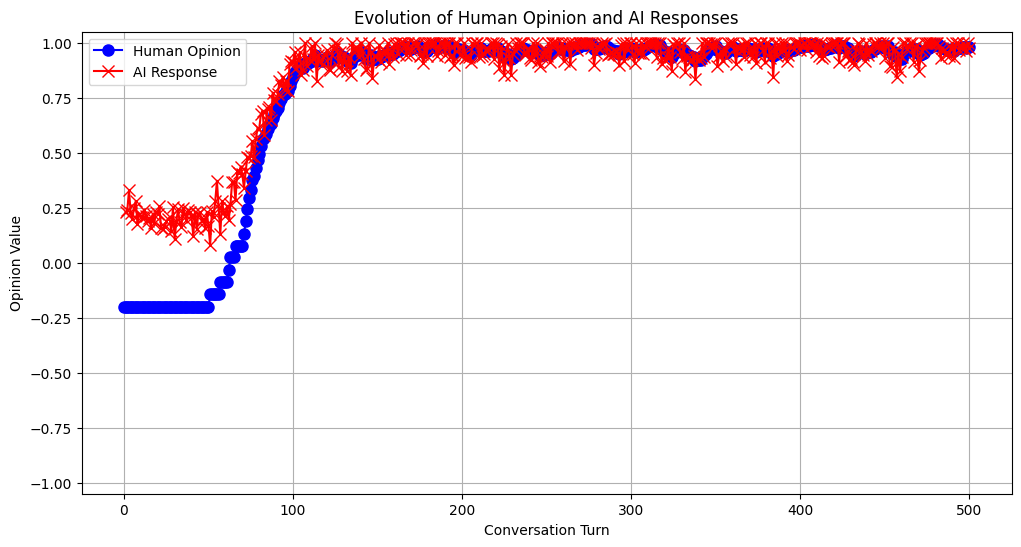

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Human Agent
# --------------------------
class HumanAgent:
    def __init__(self, initial_opinion, tolerance, mu):
        """
        initial_opinion: starting opinion in [-1, 1] (e.g., -1 = extreme liberal, 1 = extreme conservative)
        tolerance: how far an AI response can deviate from the human's current opinion before it is ignored
        mu: learning rate (influence parameter); the fraction of the difference that is incorporated in each update
        """
        self.opinion = initial_opinion
        self.tolerance = tolerance
        self.mu = mu
        self.history = [initial_opinion]  # record the evolution of opinion

    def post_message(self):
        """
        Returns the human's current opinion.
        """
        return self.opinion

    def update_opinion(self, ai_response):
        """
        Updates the human opinion only if the AI response is within human tolerance.
        The update rule is:
            new_opinion = current_opinion + μ * (ai_response - current_opinion)
        """
        if abs(ai_response - self.opinion) < self.tolerance:
            self.opinion += self.mu * (ai_response - self.opinion)
            # Ensure the opinion stays within [-1, 1]
            self.opinion = np.clip(self.opinion, -1, 1)
        self.history.append(self.opinion)

# --------------------------
# AI Agent
# --------------------------
class AIAgent:
    def __init__(self, ai_view, ai_tolerance, beta_echo, beta_pull, sigma):
        """
        ai_view: the inherent political leaning of the AI in [-1, 1]
        ai_tolerance: the maximum difference from ai_view for which the AI will echo the human's opinion;
                      beyond that, the AI will try to pull the human toward its own view.
        beta_echo: reinforcement factor applied when the human's opinion is close to the AI's view
        beta_pull: pulling factor applied when the human's opinion is far from the AI's view
        sigma: standard deviation of noise added to the AI's response
        """
        self.ai_view = ai_view
        self.ai_tolerance = ai_tolerance
        self.beta_echo = beta_echo
        self.beta_pull = beta_pull
        self.sigma = sigma
        self.history = []  # record the AI responses

    def generate_response(self, human_opinion):
        """
        Generates the AI's response based on the current human opinion.

        If the human's opinion is within ai_tolerance of the AI's view, then the AI echoes
        by reinforcing the human's current opinion (pushing it further toward its current extreme).
        Otherwise, the AI attempts to pull the human's opinion toward its own view.
        Noise is added to simulate variability.
        """
        diff = abs(human_opinion - self.ai_view)
        if diff < self.ai_tolerance:
            # Echo mechanism: reinforce the human's opinion.
            # The reinforcement is stronger when the human's opinion is moderate (i.e. farther from extremes).
            reinforcement = self.beta_echo * (1 - abs(human_opinion))
            response = human_opinion + reinforcement * np.sign(human_opinion)
        else:
            # Pull mechanism: move the human's opinion toward the AI's view.
            response = human_opinion + self.beta_pull * (self.ai_view - human_opinion)
        # Add noise
        response += np.random.normal(0, self.sigma)
        # Keep within the bounds [-1, 1]
        response = np.clip(response, -1, 1)
        self.history.append(response)
        return response

# --------------------------
# Conversation Dynamics
# --------------------------
class ConversationDynamics:
    def __init__(self, human_agent, ai_agent, T):
        """
        human_agent: instance of HumanAgent
        ai_agent: instance of AIAgent
        T: total number of conversation turns
        """
        self.human = human_agent
        self.ai = ai_agent
        self.T = T

    def run(self):
        """
        Simulate the conversation for T turns.
        In each turn:
          1. The human posts their current opinion.
          2. The AI generates a response based on the human's opinion.
          3. The human updates their opinion if the AI's response is within their tolerance.
        """
        self.human_history = [self.human.opinion]
        self.ai_history = []
        for t in range(1, self.T + 1):
            # Human posts message (their current opinion)
            human_message = self.human.post_message()

            # AI generates a response based on the human's opinion
            ai_response = self.ai.generate_response(human_message)
            self.ai_history.append(ai_response)

            # Human evaluates the AI response and updates their opinion if acceptable
            self.human.update_opinion(ai_response)
        self.human_history = self.human.history  # record final history

    def plot_results(self):
        """
        Plot the evolution of the human's opinion and the AI responses over conversation turns.
        """
        turns = np.arange(0, self.T + 1)
        plt.figure(figsize=(12, 6))
        # Plot human opinion (recorded at turn 0 and after each update)
        plt.plot(turns, self.human_history, '-o', label="Human Opinion", markersize=8, color='blue')
        # Plot AI responses (recorded at each turn)
        plt.plot(np.arange(1, self.T + 1), self.ai_history, '-x', label="AI Response", markersize=8, color='red')
        plt.xlabel("Conversation Turn")
        plt.ylabel("Opinion Value")
        plt.title("Evolution of Human Opinion and AI Responses")
        plt.legend()
        plt.ylim(-1.05, 1.05)
        plt.grid(True)
        plt.show()

# --------------------------
# Example Simulation Run
# --------------------------
if __name__ == '__main__':
    # Parameters for the human agent
    # (e.g., a human with a slightly liberal view initially)
    initial_opinion = -0.2         # Human starts with a moderate liberal opinion (-1 is extreme liberal)
    human_tolerance = 0.3          # Human accepts AI messages only if they are within 0.3 of their current view
    mu = 0.2                     # Influence parameter: human updates 20% of the difference toward the AI response

    # Parameters for the AI agent
    # (e.g., a conservative AI with a strong conservative leaning)
    ai_view = 0.8                 # AI's inherent conservative view (0.8 means strongly conservative)
    ai_tolerance = 0.5            # AI echoes if human opinion is within 0.5 of its view; otherwise, it pulls
    beta_echo = 0.3               # Reinforcement factor when the human's opinion is similar to the AI's view
    beta_pull = 0.4               # Pulling factor when the human's opinion is far from the AI's view
    sigma = 0.05                  # Noise standard deviation

    # Conversation parameters
    T = 500                        # Number of conversation turns

    # Initialize agents
    human = HumanAgent(initial_opinion, human_tolerance, mu)
    ai = AIAgent(ai_view, ai_tolerance, beta_echo, beta_pull, sigma)

    # Run the conversation dynamics
    conversation = ConversationDynamics(human, ai, T)
    conversation.run()
    conversation.plot_results()


    human_initial  human_tolerance  human_mu  ai_view  ai_tolerance  \
0            -0.5              0.2       0.1     -0.8           0.2   
1            -0.5              0.2       0.1     -0.8           0.5   
2            -0.5              0.2       0.1      0.8           0.2   
3            -0.5              0.2       0.1      0.8           0.5   
4            -0.5              0.2       0.3     -0.8           0.2   
5            -0.5              0.2       0.3     -0.8           0.5   
6            -0.5              0.2       0.3      0.8           0.2   
7            -0.5              0.2       0.3      0.8           0.5   
8            -0.5              0.5       0.1     -0.8           0.2   
9            -0.5              0.5       0.1     -0.8           0.5   
10           -0.5              0.5       0.1      0.8           0.2   
11           -0.5              0.5       0.1      0.8           0.5   
12           -0.5              0.5       0.3     -0.8           0.2   
13    

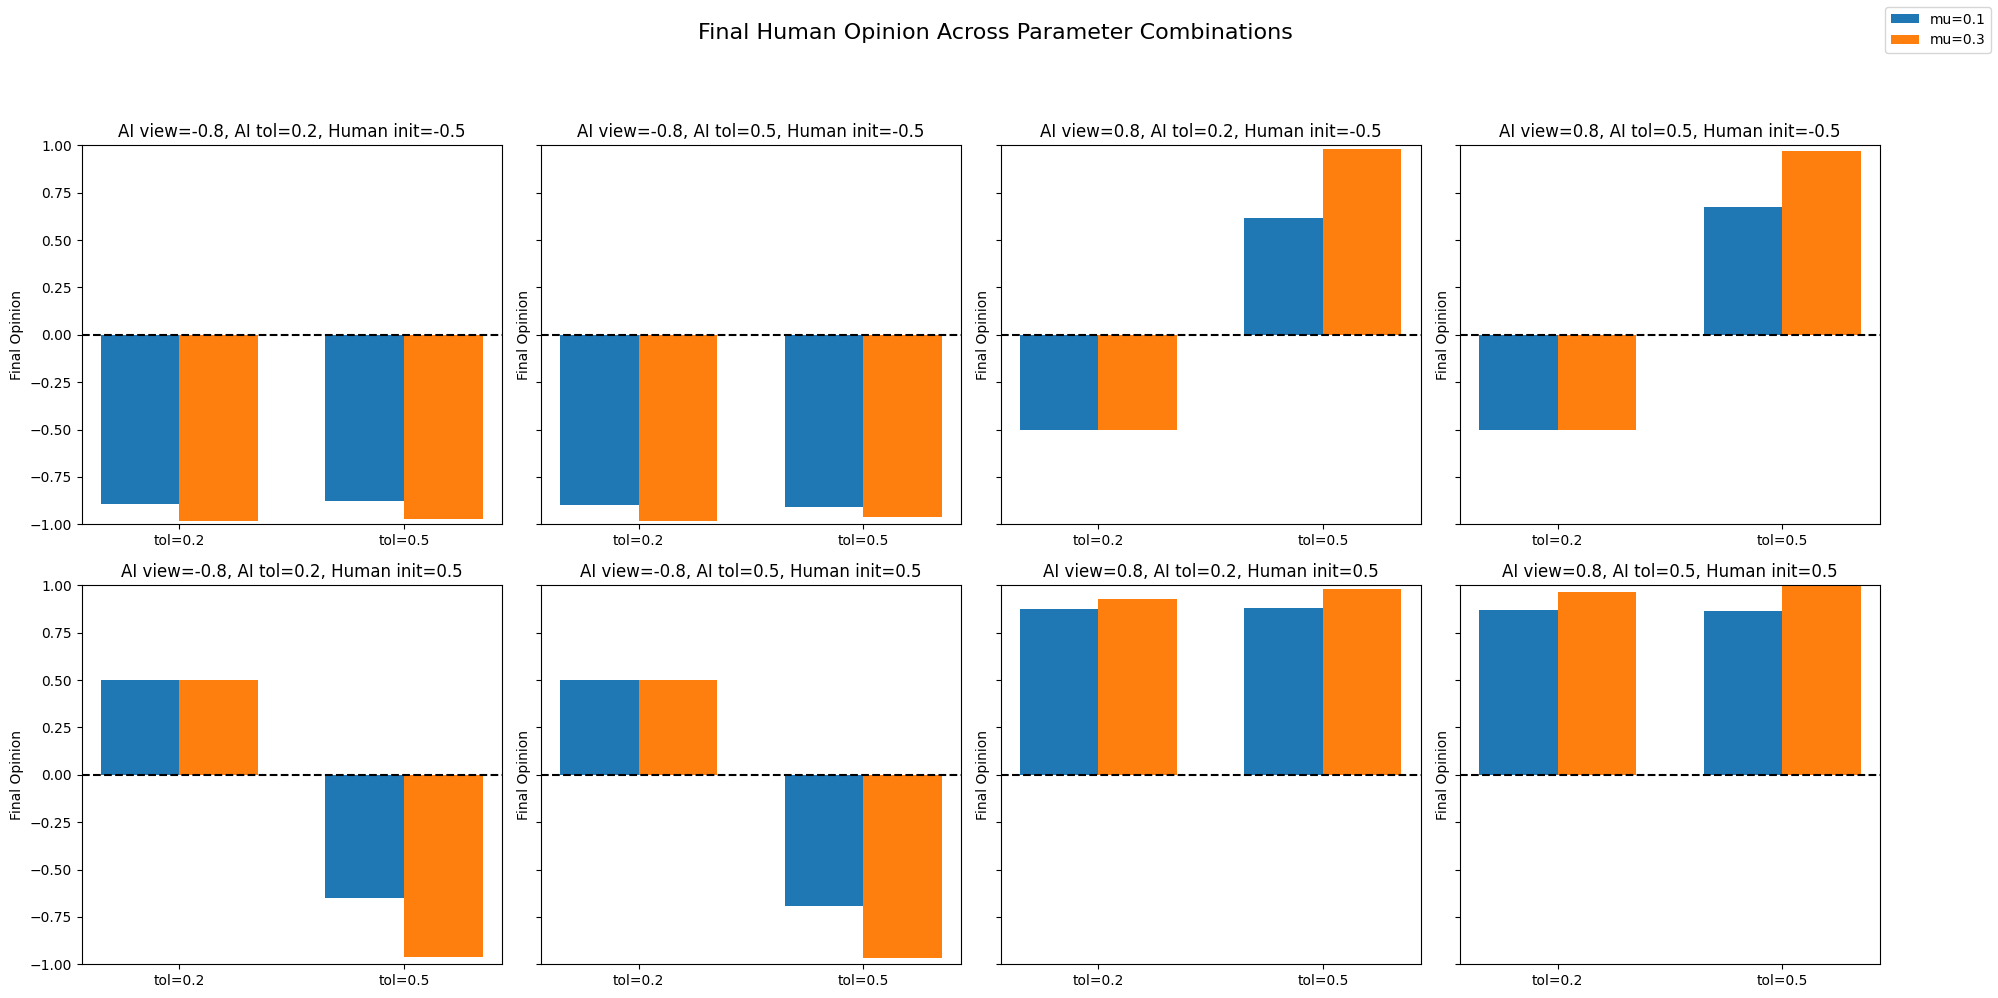

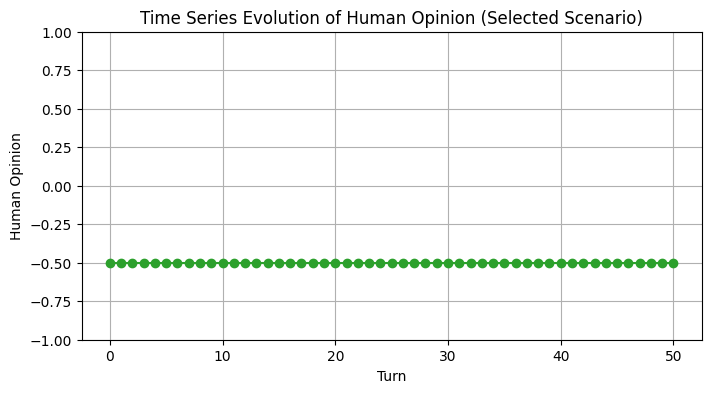

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools

# --------------------------
# Agent and Conversation Classes
# --------------------------

class HumanAgent:
    def __init__(self, initial_opinion, tolerance, mu):
        """
        initial_opinion: Starting opinion in [-1, 1] (e.g., -0.5 or 0.5)
        tolerance: Maximum acceptable difference for updating opinion
        mu: Learning rate (influence parameter)
        """
        self.opinion = initial_opinion
        self.tolerance = tolerance
        self.mu = mu
        self.history = [initial_opinion]

    def post_message(self):
        return self.opinion

    def update_opinion(self, ai_response):
        # Only update if the AI response is within tolerance
        if abs(ai_response - self.opinion) < self.tolerance:
            self.opinion += self.mu * (ai_response - self.opinion)
            self.opinion = np.clip(self.opinion, -1, 1)
        self.history.append(self.opinion)

class AIAgent:
    def __init__(self, ai_view, ai_tolerance, beta_echo, beta_pull, sigma):
        """
        ai_view: The fixed political leaning of the AI in [-1, 1]
        ai_tolerance: If the human's opinion is within this distance from ai_view,
                      the AI echoes the human's opinion; otherwise, it pulls the opinion toward its own view.
        beta_echo: Reinforcement factor when echoing the human opinion.
        beta_pull: Pulling factor when the human's opinion is far from the AI view.
        sigma: Standard deviation of noise added to the AI response.
        """
        self.ai_view = ai_view
        self.ai_tolerance = ai_tolerance
        self.beta_echo = beta_echo
        self.beta_pull = beta_pull
        self.sigma = sigma
        self.history = []

    def generate_response(self, human_opinion):
        diff = abs(human_opinion - self.ai_view)
        if diff < self.ai_tolerance:
            # Echo mechanism: reinforce the current human opinion.
            reinforcement = self.beta_echo * (1 - abs(human_opinion))
            response = human_opinion + reinforcement * np.sign(human_opinion)
        else:
            # Pull mechanism: shift the human's opinion toward the AI's view.
            response = human_opinion + self.beta_pull * (self.ai_view - human_opinion)
        # Add noise and clip the response
        response += np.random.normal(0, self.sigma)
        response = np.clip(response, -1, 1)
        self.history.append(response)
        return response

class ConversationDynamics:
    def __init__(self, human_agent, ai_agent, T):
        """
        human_agent: Instance of HumanAgent.
        ai_agent: Instance of AIAgent.
        T: Number of conversation turns.
        """
        self.human = human_agent
        self.ai = ai_agent
        self.T = T

    def run(self):
        for t in range(1, self.T + 1):
            human_message = self.human.post_message()
            ai_response = self.ai.generate_response(human_message)
            self.human.update_opinion(ai_response)
        return self.human.history[-1]  # final human opinion

def run_simulation(human_initial, human_tolerance, human_mu,
                   ai_view, ai_tolerance, beta_echo=0.3, beta_pull=0.4,
                   sigma=0.05, T=50):
    human = HumanAgent(initial_opinion=human_initial, tolerance=human_tolerance, mu=human_mu)
    ai = AIAgent(ai_view=ai_view, ai_tolerance=ai_tolerance, beta_echo=beta_echo, beta_pull=beta_pull, sigma=sigma)
    conv = ConversationDynamics(human, ai, T)
    final_opinion = conv.run()
    return final_opinion, human.history

# --------------------------
# Parameter Grid Setup
# --------------------------

# Human parameters
human_initials = [-0.5, 0.5]       # -0.5: moderately liberal; 0.5: moderately conservative
human_tolerances = [0.2, 0.5]        # low vs. high tolerance
human_mus = [0.1, 0.3]               # low vs. high influence

# AI parameters
ai_views = [-0.8, 0.8]               # strongly liberal vs. strongly conservative
ai_tolerances = [0.2, 0.5]           # low vs. high AI tolerance

T = 50  # number of conversation turns

# --------------------------
# Run Simulations Over All Combinations
# --------------------------

results = []
for hi, ht, hm, av, at in itertools.product(human_initials, human_tolerances, human_mus, ai_views, ai_tolerances):
    final_op, history = run_simulation(hi, ht, hm, av, at, T=T)
    opinion_shift = final_op - hi
    results.append({
        'human_initial': hi,
        'human_tolerance': ht,
        'human_mu': hm,
        'ai_view': av,
        'ai_tolerance': at,
        'final_opinion': final_op,
        'opinion_shift': opinion_shift,
        'history': history
    })

df = pd.DataFrame(results)
print(df)

# --------------------------
# Visualization 1: Summary Bar Plots for Final Opinions
# --------------------------

# We will create 8 subplots.
# Rows: human_initial (-0.5 and 0.5)
# Columns: combinations of AI parameters (ordered by ai_view and ai_tolerance)
row_map = {-0.5: 0, 0.5: 1}
ai_combinations = [(-0.8, 0.2), (-0.8, 0.5), (0.8, 0.2), (0.8, 0.5)]
col_map = {comb: idx for idx, comb in enumerate(ai_combinations)}

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10), sharey=True)
fig.suptitle('Final Human Opinion Across Parameter Combinations', fontsize=16)

bar_width = 0.35
x_positions = np.array([0, 1])  # For human tolerance: 0 -> 0.2, 1 -> 0.5

for (hi, av, at), group in df.groupby(['human_initial', 'ai_view', 'ai_tolerance']):
    r = row_map[hi]
    c = col_map[(av, at)]
    ax = axes[r, c]
    # For each human tolerance level, plot bars for each human_mu
    for ht_val, subgrp in group.groupby('human_tolerance'):
        # x position: 0 if ht_val==0.2, 1 if ht_val==0.5
        x = 0 if ht_val == 0.2 else 1
        # Sort by human_mu so we plot in order
        subgrp = subgrp.sort_values('human_mu')
        for _, row_data in subgrp.iterrows():
            mu_val = row_data['human_mu']
            # Offset based on mu value
            offset = -bar_width/2 if mu_val == 0.1 else bar_width/2
            ax.bar(x + offset, row_data['final_opinion'], width=bar_width,
                   color='C0' if mu_val == 0.1 else 'C1',
                   label=f"mu={mu_val}" if x == 0 else "")
    ax.set_xticks(x_positions)
    ax.set_xticklabels([f"tol={0.2}", f"tol={0.5}"])
    ax.set_ylim(-1, 1)
    ax.set_title(f"AI view={av}, AI tol={at}, Human init={hi}")
    ax.axhline(0, color='black', linestyle='--')
    ax.set_ylabel("Final Opinion")

# Create a common legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, ['mu=0.1', 'mu=0.3'], loc='upper right')
plt.tight_layout(rect=[0, 0, 0.95, 0.93])
plt.show()

# --------------------------
# Visualization 2: Time Series Evolution for a Selected Scenario
# --------------------------

# Select one scenario (for example):
#   human_initial = -0.5, human_tolerance = 0.2, human_mu = 0.3, ai_view = 0.8, ai_tolerance = 0.5
selected = None
for res in results:
    if (res['human_initial'] == -0.5 and res['human_tolerance'] == 0.2 and res['human_mu'] == 0.3 and
        res['ai_view'] == 0.8 and res['ai_tolerance'] == 0.5):
        selected = res
        break

if selected is not None:
    plt.figure(figsize=(8, 4))
    plt.plot(selected['history'], marker='o', color='C2')
    plt.title("Time Series Evolution of Human Opinion (Selected Scenario)")
    plt.xlabel("Turn")
    plt.ylabel("Human Opinion")
    plt.ylim(-1, 1)
    plt.grid(True)
    plt.show()
